In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import norm
from scipy.optimize import bisect

In [2]:
data = pd.read_csv('IV_Surface_Europe.csv')
data

,symbol,exchange,date,period,strike,out-of-the-money %,call/put,iv,delta
0,DAX,DE,03/30/17,30,12266.347,0,C,0.143699,0.508217
1,DAX,DE,03/30/17,30,12266.347,0,P,0.151877,-0.491315
2,DAX,DE,03/30/17,30,12879.663,5,C,0.124702,0.089014
3,DAX,DE,03/30/17,30,11653.029,5,P,0.176705,-0.149674
4,DAX,DE,03/30/17,30,13492.981,10,C,0.119207,0.002788
...,...,...,...,...,...,...,...,...,...
463,SX5E,NaN,03/30/17,1080,1740.835,50,P,0.265267,-0.056235
464,SX5E,NaN,03/30/17,1080,5396.588,55,C,0.189978,0.065404
465,SX5E,NaN,03/30/17,1080,1566.751,55,P,0.277890,-0.039572
466,SX5E,NaN,03/30/17,1080,5570.672,60,C,0.190815,0.055017


In [3]:
df = data[data.symbol == 'SX5E']
print('symbol : ', df.symbol.iloc[0],
      '\nexchange : ', df.exchange.iloc[0],
      '\ndate : ', df.date.iloc[0])
df_put = df[df['call/put'] == 'P']
df = df[df['call/put'] == 'C']
df = df.drop(['symbol', 'exchange', 'date', 'call/put'], axis=1)
df_put = df_put.drop(['symbol', 'exchange', 'date', 'call/put'], axis=1)
df

symbol :  SX5E 
exchange :  nan 
date :  03/30/17


,period,strike,out-of-the-money %,iv,delta
234,30,3481.670,0,0.156179,0.474439
236,30,3655.753,5,0.129746,0.081631
238,30,3829.837,10,0.124081,0.002834
240,30,4003.920,15,0.123716,0.000028
242,30,4178.004,20,0.123716,0.000000
...,...,...,...,...,...
458,1080,4874.338,40,0.188605,0.111777
460,1080,5048.421,45,0.188462,0.092785
462,1080,5222.505,50,0.188477,0.076953
464,1080,5396.588,55,0.189978,0.065404


In [4]:
S0 = df.strike.iloc[0]

In [5]:
df_iv = df.pivot(index='period', columns='strike', values='iv')
df_iv.columns = df_iv.columns / S0
df_iv

strike,1.00,1.05,1.10,1.15,1.20,1.25,1.30,1.35,1.40,1.45,1.50,1.55,1.60
period,,,,,,,,,,,,,
30,0.156179,0.129746,0.124081,0.123716,0.123716,0.123716,0.123716,0.123716,0.123716,0.123716,0.123716,0.123716,0.123716
60,0.173010,0.150996,0.136146,0.134447,0.134447,0.134447,0.134447,0.134447,0.134447,0.134447,0.134447,0.134447,0.134447
90,0.169280,0.152572,0.141411,0.137776,0.137364,0.137327,0.137327,0.137327,0.137327,0.137327,0.137327,0.137327,0.137327
120,0.169588,0.154705,0.144153,0.139173,0.138100,0.138001,0.138001,0.138001,0.138001,0.138001,0.138001,0.138001,0.138001
150,0.169773,0.155972,0.145774,0.140004,0.138539,0.138404,0.138404,0.138404,0.138404,0.138404,0.138404,0.138404,0.138404
180,0.170239,0.157322,0.147478,0.141270,0.139153,0.138766,0.138919,0.138919,0.138919,0.138919,0.138919,0.138919,0.138919
360,0.175044,0.165858,0.158251,0.152052,0.147618,0.147097,0.147097,0.147097,0.147097,0.147097,0.147097,0.147097,0.147097
720,0.183455,0.178594,0.174512,0.171090,0.168351,0.167460,0.166783,0.166408,0.166101,0.165946,0.165946,0.165946,0.165946
1080,0.195291,0.193289,0.191633,0.190257,0.189154,0.188328,0.187172,0.188046,0.188605,0.188462,0.188477,0.189978,0.190815


<IPython.core.display.Javascript object>


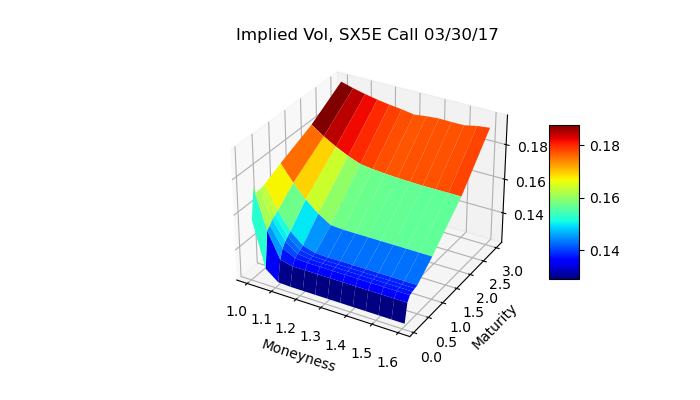

Text(0.5, 0.92, 'Implied Vol, SX5E Call 03/30/17')

In [6]:
X, Y = df_iv.columns.values, df_iv.index.values / 360
X, Y = np.meshgrid(X, Y)
Z = df_iv.values
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')

mycmap = plt.get_cmap('jet')
surf = ax.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Vol')
plt.title('Implied Vol, SX5E Call 03/30/17')

In [7]:
def BS_original(s, k, r, sigma, T):
    d1 = (np.log(s/k) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = s * norm.cdf(d1) - k * np.exp(-r * T) * norm.cdf(d2)
    return C

def BS_original_put(s, k, r, sigma, T):
    d1 = (np.log(s/k) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = -s * norm.cdf(-d1) + k * np.exp(-r * T) * norm.cdf(-d2)
    return C

In [8]:
rate = 0.025

prices = []
mat_norm = [m / 360 for m in df_iv.index]
for m in range(len(df_iv.index)):
    line = []
    for k in range(len(df_iv.columns)):
        price = BS_original(S0, df_iv.columns[k]*S0, rate, df_iv[df_iv.columns[k]].iloc[m], mat_norm[m])
        line.append(price)
    prices.append(line)
prices = np.array(prices)

<IPython.core.display.Javascript object>


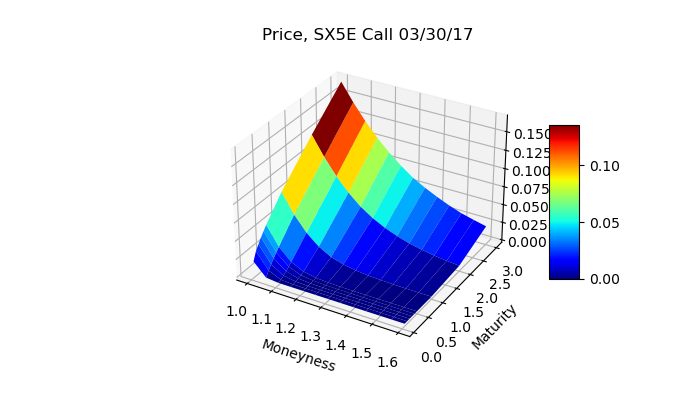

Text(0.5, 0.92, 'Price, SX5E Call 03/30/17')

In [9]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')

mycmap = plt.get_cmap('jet')
surf = ax.plot_surface(X, Y, prices/S0, cmap=mycmap)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price / Spot')
plt.title('Price, SX5E Call 03/30/17')

<IPython.core.display.Javascript object>


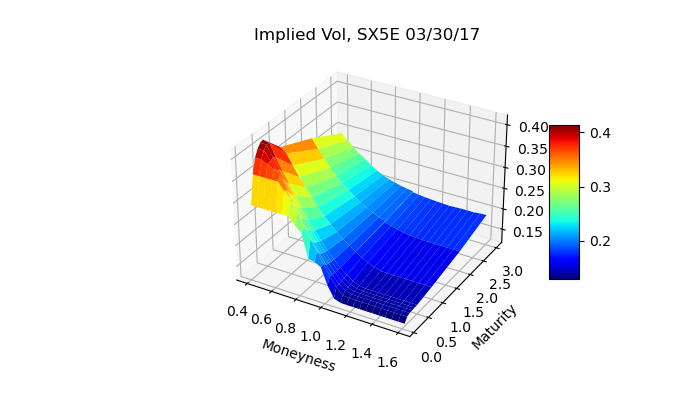

Text(0.5, 0.92, 'Implied Vol, SX5E 03/30/17')

In [10]:
df_put_iv = df_put.pivot(index='period', columns='strike', values='iv')
df_put_iv.columns = df_put_iv.columns / S0
df_iv_2 = pd.concat([df_put_iv, df_iv], axis=1)

X, Y = df_iv_2.columns.values, df_iv_2.index.values / 360
X, Y = np.meshgrid(X, Y)
Z = df_iv_2.values
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')

mycmap = plt.get_cmap('jet')
surf = ax.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Vol')
plt.title('Implied Vol, SX5E 03/30/17')

<IPython.core.display.Javascript object>


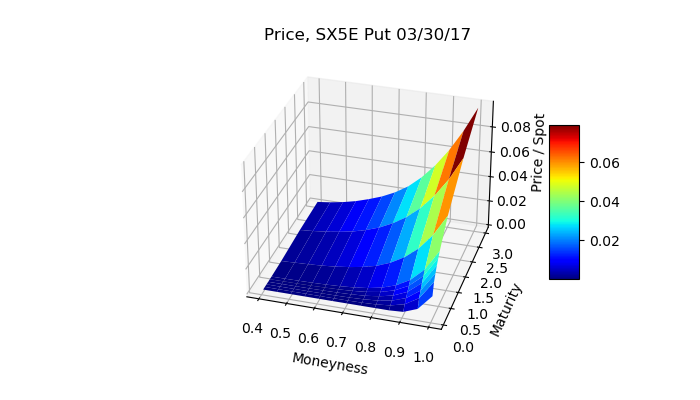

Text(0.5, 0.92, 'Price, SX5E Put 03/30/17')

In [11]:
prices_put = []
mat_norm = [m / 360 for m in df_put_iv.index]
for m in range(len(df_put_iv.index)):
    line = []
    for k in range(len(df_put_iv.columns)):
        price = BS_original_put(S0, df_put_iv.columns[k]*S0, rate, df_put_iv[df_put_iv.columns[k]].iloc[m], mat_norm[m])
        line.append(price)
    prices_put.append(line)
prices_put = np.array(prices_put)

X, Y = df_put_iv.columns.values, df_put_iv.index.values / 360
X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')

mycmap = plt.get_cmap('jet')
surf = ax.plot_surface(X, Y, prices_put/S0, cmap=mycmap)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price / Spot')
plt.title('Price, SX5E Put 03/30/17')

In [12]:
df_prices = pd.DataFrame(prices, index=df_iv.index, columns=df_iv.columns)
df_prices_final = df_prices[df_prices.columns[:6]].loc[:180]

In [16]:
df_prices_final

strike,1.00,1.05,1.10,1.15,1.20,1.25
period,,,,,,
30,66.241659,6.793825,0.189601,0.001792,0.000006,6.443849e-09
60,105.289753,30.099829,4.281636,0.448907,0.032611,1.595148e-03
90,128.327883,48.978092,12.756034,2.564572,0.428821,5.743814e-02
120,150.315828,67.465812,23.112014,6.376665,1.555788,3.314164e-01
150,170.073822,84.635528,34.168245,11.477046,3.536133,9.953240e-01
180,188.581738,101.240646,45.928350,17.814644,6.395598,2.153825e+00


<IPython.core.display.Javascript object>


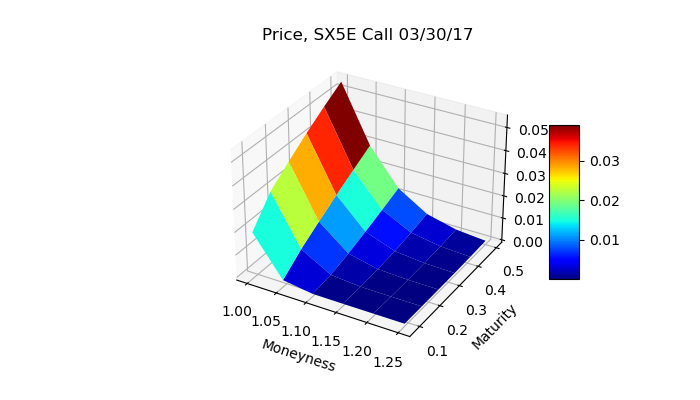

Text(0.5, 0.92, 'Price, SX5E Call 03/30/17')

In [15]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')
X, Y = df_prices_final.columns.values, df_prices_final.index.values / 360
X, Y = np.meshgrid(X, Y)

mycmap = plt.get_cmap('jet')
surf = ax.plot_surface(X, Y, df_prices_final.values/S0, cmap=mycmap)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price / Spot')
plt.title('Price, SX5E Call 03/30/17')

In [17]:
# (df_prices_final/S0).to_csv('target_SX5E_price.csv')